<a href="https://colab.research.google.com/github/victorbahlangene/NLP-Disaster-Tweets-kaggle-comp/blob/main/Natural_Language_Processing_with_Disaster_Tweets_Part_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Natural Language Processing Competition - Part 2

## More advancced methods

## Introduction business Problem

## Data

## Methodology

1. Notebook Setup
2. Imports and EDA(Exploritory Data Analysis)
3. Training
4. Create a validation set
5. Initial model
6. Improving model
7. Special tokens
8. Cross-validation
9. huggingface login
10. Confussion Matrix
11. Saving and Sharing model
12. Use the model via pipeline


## Analysis

### Notebook Setup


In [1]:
# Check if you are in a Kagggle enviroment #
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# to use kaggle api #
!pip install -q kaggle

# kaggle API creds #
creds = '{"username":"victorbahlangene","key":"2cd1abe2f1c35ea3060e6a2f18a055ea"}'

# Then execute this cell (this only needs to be run once) #
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

try: import fastkaggle
except ModuleNotFoundError:
    !pip install -q fastkaggle

from fastkaggle import *

# competion name #
comp = 'nlp-getting-started'

# path to where data will be downloaded #
path = setup_comp(comp, install='fastai')


100%|██████████| 593k/593k [00:00<00:00, 66.0MB/s]

A lot of the basic imports you'll want (`np`, `pd`, `plt`, etc) are provided by fastai, so let's grab them in one line:

In [2]:
from fastai.imports import *

### Imports and EDA(Exploritory Data Analysis)


In [3]:
path.ls()

(#3) [Path('nlp-getting-started/test.csv'),Path('nlp-getting-started/train.csv'),Path('nlp-getting-started/sample_submission.csv')]

**Training data**

In [4]:
df = pd.read_csv(path/'train.csv', index_col=0)
df

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1


Basic information the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


keyword col

In [6]:
df.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

location col

In [7]:
df.location.value_counts()[:15]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
Name: location, dtype: int64

Horizontal bar graph to show location col distribution

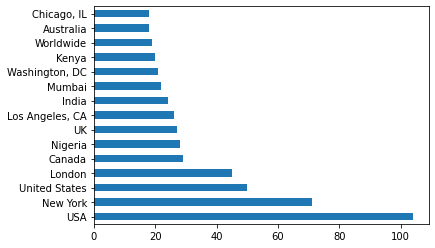

In [8]:
top_15_locations = df.location.value_counts()[:15]
top_15_locations.plot(kind="barh");

Change dtype of 'target' col from int to float

In [5]:
df = df.astype({"target": float})

In [10]:
df.dtypes

id            int64
keyword      object
location     object
text         object
target      float64
dtype: object

**Test data**

In [7]:
eval_df = pd.read_csv(path/'test.csv')
len(eval_df)

3263

Test data as a .csv file

In [8]:
eval_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3


### Training


Imports for training

In [ ]:
!pip install -q transformers
!pip install -q datasets

# pytoch dataloader #
from torch.utils.data import DataLoader

# warnings,huggingface transformers,logging, pytorch #
import warnings,transformers,logging,torch

# for transformers training #
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from datasets import load_dataset, Dataset, DatasetDict

remove huggingface warnings

In [10]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

small fast model

In [11]:
model_nm = 'microsoft/deberta-v3-small'

In [ ]:
# needed to make 'microsoft/deberta-v3-small' run #
!pip install sentencepiece

In [ ]:
tokz = AutoTokenizer.from_pretrained(model_nm)

#### Make datasets

make basic dataset with basic concatination. First replace NaN with 

In [18]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Keyword column.NaN = "IGNORE KEYWORD"

In [15]:
df.keyword.fillna("IGNORE KEYWORD", inplace=True)

view frequency of each keyword

In [16]:
df.keyword.value_counts()

IGNORE KEYWORD           61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

check null values after addition

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   keyword   7613 non-null   object 
 1   location  5080 non-null   object 
 2   text      7613 non-null   object 
 3   target    7613 non-null   float64
dtypes: float64(1), object(3)
memory usage: 297.4+ KB


location column.NaN = "IGNORE LOCATION"

In [18]:
df.location.fillna("IGNORE LOCATION", inplace=True)

check frequency of each location

In [24]:
df.location.value_counts()

IGNORE LOCATION                 2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: location, Length: 3342, dtype: int64

View null values

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   keyword   7613 non-null   object 
 1   location  7613 non-null   object 
 2   text      7613 non-null   object 
 3   target    7613 non-null   float64
dtypes: float64(1), object(3)
memory usage: 297.4+ KB


In [20]:
df.head(2)

,keyword,location,text,target
id,,,,
1,IGNORE KEYWORD,IGNORE LOCATION,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0
4,IGNORE KEYWORD,IGNORE LOCATION,Forest fire near La Ronge Sask. Canada,1.0


**Apply same changes to the eval_df(test dataset)**

In [21]:
# sample test data #
eval_df.head(1)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash


In [24]:
eval_df.keyword.fillna("IGNORE KEYWORD", inplace=True)
eval_df.location.fillna("IGNORE LOCATION", inplace=True)

show NaN values in the test data

In [25]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3263 non-null   object
 2   location  3263 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


create train and evaluation dataset

In [26]:
ds = Dataset.from_pandas(df).rename_column("target", "label")
eval_ds = Dataset.from_pandas(eval_df)

train dataset

In [27]:
ds

Dataset({
    features: ['keyword', 'location', 'text', 'label', 'id'],
    num_rows: 7613
})

sample data

In [28]:
ds[:1]

{'keyword': ['IGNORE KEYWORD'],
 'location': ['IGNORE LOCATION'],
 'text': ['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'],
 'label': [1.0],
 'id': [1]}

test dataset

In [29]:
eval_ds

Dataset({
    features: ['id', 'keyword', 'location', 'text'],
    num_rows: 3263
})

sample data

In [30]:
eval_ds[:1]

{'id': [0],
 'keyword': ['IGNORE KEYWORD'],
 'location': ['IGNORE LOCATION'],
 'text': ['Just happened a terrible car crash']}

#### Tokenization function

In [34]:
def tok_func(x):
  return tokz(x["text"])

Tokenize data for basic model(initial model)

In [35]:
ds

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'label'],
    num_rows: 7613
})

In [36]:
inps = "keyword","location","text"
tok_ds = ds.map(tok_func, batched=True, batch_size=None, remove_columns=inps)

  0%|          | 0/1 [00:00<?, ?ba/s]

tokenized dataset

In [37]:
tok_ds

Dataset({
    features: ['id', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7613
})

view tokenization for first data entry

In [39]:
print(tok_ds[:1])

{'id': [1], 'label': [1.0], 'input_ids': [[1, 581, 65453, 281, 262, 18037, 265, 291, 953, 117831, 903, 4924, 17018, 43632, 381, 305, 2]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


### Create a validation set


Using 'keyword' col. create a randomly shuffled list of keywords.

In [40]:
keywords = df.keyword.unique()
np.random.seed(42)
np.random.shuffle(keywords)
keywords[:5]

array(['outbreak', 'wildfire', 'avalanche', 'screamed', 'police'],
      dtype=object)

25% of keywords to go in the validation set:

In [42]:
val_prop = 0.25
val_sz = int(len(keywords)*val_prop)
val_keywords = keywords[:val_sz]

length of validation keywords and sample keywords

In [43]:
len(val_keywords), val_keywords[:5]

(55, array(['outbreak', 'wildfire', 'avalanche', 'screamed', 'police'],
       dtype=object))

Now we can get a list of which rows match `val_keywords`, and get their indices:

In [44]:
is_val = np.isin(df.keyword, val_keywords)
idxs = np.arange(len(df))
val_idxs = idxs[is_val]
trn_idxs = idxs[~is_val]
len(trn_idxs), len(val_idxs)

(5757, 1856)

Our training and validation `Dataset`s can now be selected, and put into a `DatasetDict` ready for training:

In [45]:
dds = DatasetDict({
    "train": tok_ds.select(trn_idxs),
    "valid": tok_ds.select(val_idxs)
}) 

In [46]:
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5757
    })
    valid: Dataset({
        features: ['id', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1856
    })
})

Check the distribution of the target col of the dataframe using this validation dataset

In [47]:
df.iloc[trn_idxs].target.mean(), df.iloc[val_idxs].target.mean()

(0.4359909675178044, 0.41002155172413796)

### Initial model


**Model metrics**

In [31]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

learning rate, batch size, wd, epochs

In [32]:
lr,bs = 8e-5,32
wd,epochs = 0.01,4

TrainingArguments

In [50]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=wd, report_to='none')

Trainer

In [52]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=2)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['valid'],
               tokenizer=tokz, compute_metrics=compute_metrics)

Downloading:   0%|          | 0.00/286M [00:00<?, ?B/s]

train model

In [53]:
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.448056,0.815194,0.815138
2,No log,0.481532,0.813039,0.812825


From part 1 using a different validation set

| Epoch | Training Loss | Validation Loss | Accuracy |    F1    |
|-------|---------------|-----------------|----------|----------|
|     1 | No log        |        0.382815 | 0.841506 | 0.841445 |
|     2 | No log        |        0.401400 | 0.856392 | 0.855747 |

basic model. performs worse than the model in part 1. The only thing we changed from the `part 1` dataset is the validation set. Thus we will keep using our initial validation set.

### Use validation set of Part 1


In [33]:
from sklearn.model_selection import train_test_split

# make a copy of df #
df_trn = df.copy()

# dependant variable #
target = df_trn.target

df_trn.drop(["target"], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(df_trn, target, 
                                                        test_size=0.15, 
                                                        random_state=42, 
                                                        stratify=target)

X_train["label"] = y_train
X_valid["label"] = y_valid

train_ds = Dataset.from_pandas(X_train)
valid_ds = Dataset.from_pandas(X_valid)

tweets = DatasetDict()
tweets["train"] = train_ds
tweets["valid"] = valid_ds

tweets

DatasetDict({
    train: Dataset({
        features: ['keyword', 'location', 'text', 'label', 'id'],
        num_rows: 6471
    })
    valid: Dataset({
        features: ['keyword', 'location', 'text', 'label', 'id'],
        num_rows: 1142
    })
})

**Tokenize validaiton set**

In [34]:
def tokenize(batch):
  return tokz(batch["text"], padding=True, truncation=True)

**Tokenized tweets**

In [35]:
tweets_tokz = tweets.map(tokenize, batched=True, batch_size=None)
tweets_tokz

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['keyword', 'location', 'text', 'label', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6471
    })
    valid: Dataset({
        features: ['keyword', 'location', 'text', 'label', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1142
    })
})

train

In [36]:
model_nm

'microsoft/deberta-v3-small'

model and trainer

In [62]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=2)
trainer = Trainer(model, args, train_dataset=tweets_tokz['train'], eval_dataset=tweets_tokz['valid'],
               tokenizer=tokz, compute_metrics=compute_metrics)

train

In [63]:
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.378727,0.843257,0.842981
2,No log,0.404778,0.848511,0.848373


The basic idea is there is no perfect method to create a validation set. Its a matter of trail and error

### Improving model


New Tokenize func

We are tokenizing the imputs beacuse after our data augmentations, the 'inputs' col is where the data will be located

In [37]:
def tokenize_inputs(batch):
  return tokz(batch["inputs"], padding=True, truncation=True)

Function to get a tokenized dataset dictionary for a dataframe

In [38]:
def get_dds(df):

  # dependant variable #
  target = df.target

  # make copy of df, so that our initial df will not be changed #
  df_int = df.copy()
  df_int.drop(["target"], axis=1, inplace=True)

  X_trn, X_val, y_trn, y_val = train_test_split(df_int, target, test_size=0.15, random_state=42, stratify=target)
  
  X_trn["label"] = y_trn
  X_val["label"] = y_val

  trn_ds = Dataset.from_pandas(X_trn)
  val_ds = Dataset.from_pandas(X_val)

  dd = DatasetDict()
  dd["train"] = trn_ds
  dd["valid"] = val_ds

  toRemoveCols = 'keyword', 'location', 'text'
  
  dds = dd.map(tokenize_inputs, batched=True, batch_size=None, remove_columns=toRemoveCols)
  return dds

Function to create a `Trainer`

In [39]:
def get_model(): return AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=2)

def get_trainer(dds, model=None):
    if model is None: model = get_model()
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['valid'],
                   tokenizer=tokz, compute_metrics=compute_metrics)

#### Method of cancatination

1. basic concatination 
2. Using a special `'[SEP]'` token for concatination
3. Using `" [s] "` for concatination
4. lower case


##### 1. Using basic contatination

In [87]:
df["inputs"] = "KEYWORD: " + df["keyword"] + "; TEXT1: " + df["text"] + "; LOCATION: " + df["location"] 
dds = get_dds(df)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

show tokenized dataset

In [88]:
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'inputs', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6471
    })
    valid: Dataset({
        features: ['id', 'inputs', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1142
    })
})

create train model

In [89]:
get_trainer(dds).train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.433474,0.851138,0.850139
2,No log,0.415824,0.830998,0.831470
3,0.400700,0.416729,0.842382,0.841323
4,0.400700,0.496816,0.836252,0.836351


##### 2. Using a special '[SEP]' token for concatination

In [73]:
sep = tokz.sep_token
sep

'[SEP]'

apply to full df

In [75]:
df["inputs"] = df.keyword + sep + df.location + sep + df.text
dds = get_dds(df)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

show tokenized dataset

In [76]:
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'inputs', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6471
    })
    valid: Dataset({
        features: ['id', 'inputs', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1142
    })
})

 create and train a model

In [77]:
get_trainer(dds).train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.391336,0.846760,0.846252
2,No log,0.402441,0.848511,0.847695
3,0.393300,0.465520,0.830998,0.831442
4,0.393300,0.529429,0.830123,0.830637


##### 3. Using " [s] " for concatination

apply to full dataframe

In [79]:
sep_normal = " [s] "
df["inputs"] = df.keyword + sep_normal + df.location + sep_normal + df.text
dds = get_dds(df)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [81]:
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'inputs', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6471
    })
    valid: Dataset({
        features: ['id', 'inputs', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1142
    })
})

train model

In [82]:
get_trainer(dds).train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.452030,0.831874,0.831650
2,No log,0.397111,0.830123,0.830687
3,0.403300,0.447127,0.837128,0.836911
4,0.403300,0.511432,0.828371,0.828495


##### 4. Lower case text

apply lower case on the most acurate concatination method(`Basic concatination`)

In [90]:
df["inputs"] = "KEYWORD: " + df["keyword"] + "; TEXT1: " + df["text"] + "; LOCATION: " + df["location"] 
df.head(1)

,id,keyword,location,text,target,inputs
0,1,IGNORE KEYWORD,IGNORE LOCATION,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,KEYWORD: IGNORE KEYWORD; TEXT1: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all; LOCATION: IGNORE LOCATION


In [92]:
df["inputs"] = df.inputs.str.lower()
dds = get_dds(df)
get_trainer(dds).train();

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.437939,0.830998,0.831285
2,No log,0.389241,0.849387,0.849099
3,0.402600,0.450630,0.839755,0.838710
4,0.402600,0.519414,0.830998,0.831060


not much improvement. The basic model performed the best so we will use that moving forward

### huggingface login


In [40]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


### Final model for part 2 notebook 

**Concatination, tokenized datasets**

In [41]:
df["inputs"] = "KEYWORD: " + df["keyword"] + "; TEXT1: " + df["text"] + "; LOCATION: " + df["location"] 
dds = get_dds(df)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

**Show tokenized dataset**

In [42]:
dds

DatasetDict({
    train: Dataset({
        features: ['inputs', 'label', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6471
    })
    valid: Dataset({
        features: ['inputs', 'label', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1142
    })
})

model name to be saved in huggingface

In [44]:
model_nm

'microsoft/deberta-v3-small'

full model name

In [79]:
full_model_name =f"{model_nm}-fine-Disaster-Tweets-Part2"
full_model_name

'microsoft/deberta-v3-small-fine-Disaster-Tweets-Part2'

new training model

In [81]:
def get_trainer_tohub(dds, output_dir, model=None):
    if model is None: model = get_model()
    args = TrainingArguments(output_dir=output_dir, learning_rate=lr, push_to_hub=True, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['valid'],
                   tokenizer=tokz, compute_metrics=compute_metrics)

get model

In [75]:
def get_model(model_nm): return AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=2)

In [82]:
model = get_model(model_nm)

**Model Trainer**

In [83]:
trainer = get_trainer_tohub(dds,full_model_name,model)

**Train model**

In [84]:
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.467010,0.851138,0.850253
2,No log,0.438115,0.845884,0.845544
3,0.401600,0.409637,0.842382,0.841261
4,0.401600,0.484947,0.827496,0.827753


## Predictions 

**Preds of validation data**

In [49]:
preds_valid = trainer.predict(dds['valid'])

metrics

In [50]:
preds_valid.metrics

{'test_loss': 0.5140437483787537,
 'test_accuracy': 0.8248686514886164,
 'test_f1': 0.8253132676115511,
 'test_runtime': 1.5913,
 'test_samples_per_second': 717.653,
 'test_steps_per_second': 11.312}

preds

In [51]:
preds_valid.predictions.argmax(-1)

array([1, 1, 0, ..., 0, 0, 1])

**Preds of test data**

evaluation dataset

In [53]:
eval_df["inputs"] = "KEYWORD: " + eval_df["keyword"] + "; TEXT1: " + eval_df["text"] + "; LOCATION: " + eval_df["location"]

In [54]:
eval_df.head(1)

,id,keyword,location,text,inputs
0,0,IGNORE KEYWORD,IGNORE LOCATION,Just happened a terrible car crash,KEYWORD: IGNORE KEYWORD; TEXT1: Just happened a terrible car crash; LOCATION: IGNORE LOCATION


In [55]:
eval_ds = Dataset.from_pandas(eval_df)

In [56]:
eval_ds

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'inputs'],
    num_rows: 3263
})

eval dataset tokenized

In [60]:
eval_dds = eval_ds.map(tokenize_inputs, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [61]:
eval_dds

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'inputs', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3263
})

In [90]:
preds_test_data = trainer.predict(eval_dds)

Pred metrics

In [91]:
preds_test_data.metrics

{'test_runtime': 4.4217,
 'test_samples_per_second': 737.959,
 'test_steps_per_second': 11.534}

Actual preds

In [92]:
preds_test_data.predictions.argmax(-1)

array([1, 1, 1, ..., 1, 1, 1])

### Confussion Matrix


### Saving and Sharing model


In [85]:
trainer.push_to_hub(commit_message="second model")

Upload file pytorch_model.bin:   0%|          | 3.34k/541M [00:00<?, ?B/s]

'https://huggingface.co/victorbahlangene/deberta-v3-small-fine-Disaster-Tweets-Part2/commit/585f2f34b7fae24f41b751e9c931fdea88f3222d'

### Use the model via pipeline

In [86]:
from transformers import pipeline

In [87]:
model_id = "victorbahlangene/deberta-v3-small-fine-Disaster-Tweets-Part2"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/880 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/400 [00:00<?, ?B/s]

In [88]:
custom_tweet = "Oh my gosh LA is in complete chaos. cant find an open ice cream shop"

preds = classifier(custom_tweet, top_k=1)

In [89]:
preds

[{'label': 'LABEL_0', 'score': 0.9395449757575989}]

## submit to kaggle

In [93]:
eval_dds

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'inputs', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3263
})

In [95]:
eval_dds["id"][:5]

[0, 2, 3, 9, 11]

In [96]:
preds_test_data.predictions.argmax(-1)

array([1, 1, 1, ..., 1, 1, 1])

In [97]:
import numpy as np

predicton_test = pd.DataFrame(data={
    "id": eval_dds["id"],
    "target": np.argmax(preds_test_data.predictions, axis=-1)
})

predicton_test.to_csv('submission.csv', index=False)

In [98]:
!head submission.csv

id,target
0,1
2,1
3,1
9,1
11,1
12,1
21,0
22,0
27,0


## Send submission to kaggle

In [99]:
if not iskaggle:
  from kaggle import api
  api.competition_submit_cli('submission.csv', 'microsoft/deberta-v3-small transformers victor 2nd submission', 
                             comp)

100%|██████████| 22.2k/22.2k [00:07<00:00, 3.22kB/s]


- Score: 0.82010

## Conclussion

worse than model in part 2

## References